# Importowanie potrzebnych bibliotek.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import KFold, train_test_split
from stackerpy import StackerModel
import matplotlib.pyplot as plt

np.random.seed(np.sum([ord(i) for i in 'StackerPy Testing']))

# Definicja metody inicjalizującej klasy StackerModel.

In [2]:
def __init__(self):
    self.X = None
    self.y = None
    self.blend = None
    self.splits = None
    self.model_feature_indices = None   
    self.model_methods = []
    self.metafeatures_df = None
    self.X_with_metafeatures = None
    self.raw_models = None
    self.fit_models = dict()
    self.fit_blended_models = dict()
    self.raw_stacker = None
    self.stacker = None

# Definicja metody validate_models sprawdzającej poprawność i typy przekazanych modeli bazowych.

In [3]:
def validate_models(self, models):
    for model in models:
        # model name
        model_name = model.__str__().split('(')[0]
        
        # assert that each model has a predict_proba or predict method
        assert any(['predict' in dir(model), 'predict_proba' in dir(model)]), \
            f"""{model_name} does not have a predict or predict_proba method"""
        
        # determine which method to use from each of the models in the ist and keep stored
        if 'predict_proba' not in dir(model) and 'predict' in dir(model):
            print(f'Note: There is no predict_proba method in {model_name}, therefore predict method will be used')
            self.model_methods.append('predict')
        
        if 'predict_proba' in dir(model):
            self.model_methods.append('predict_proba')

# Definicja metody model_predictor, w której wybieramy jeden z dwóch dostępnych predyktorów.

In [4]:
@staticmethod
def model_predictor(model, X, method):
    """
    :param model:
    :param X:
    :param method: 'predict' or 'predict_proba' as per generated list through model validation assertion
    :return:
    """
    
    predictions = None
    if method == 'predict_proba':
        predictions = model.predict_proba(X)[:, 1]
    if method == 'predict':
        predictions = model.predict(X)
    
    return predictions

# Definicja metody fit: trenowanie modeli bazowych i meta-modelu (stackera) z opcją blendingu i podziału na splity.

In [5]:
def fit(self, X, y, models, stacker, blend=False, splits=5, model_feature_indices=None):
    """
    :param X:
    :param y:
    :param models:
    :param stacker:
    :param blend:
    :param splits:
    :param model_feature_indices:
    :return:
    """
    
    # re-initialise so that you can
    self.__init__()
    
    # some saved variables during fit
    self.raw_models = models
    self.raw_stacker = stacker
    self.blend = blend
    self.splits = splits
    self.model_feature_indices = model_feature_indices
    
    self.validate_models(models)
    
    # convert X into a dataframe if not already
    if str(type(X)) != """<class 'pandas.core.frame.DataFrame'>""":
        X = pd.DataFrame(X).reset_index(drop=True)
    # convert y into a dataframe if not already
    if str(type(y)) != """<class 'pandas.core.frame.DataFrame'>""":
        y = pd.DataFrame(y).reset_index(drop=True)
    
    if self.model_feature_indices is None:
        self.model_feature_indices = [[i for i in range(X.shape[1])] for _ in models]
    
    self.model_names_list = [model.__str__().split('(')[0] for model in self.raw_models]
    self.metafeatures_df = pd.DataFrame(index=[i for i in range(X.shape[0])], columns=self.model_names_list)
    
    for model, features, method in zip(self.raw_models, self.model_feature_indices, self.model_methods):
        # model_name
        model_name = model.__str__().split('(')[0]
        
        # train model
        X_model_features = X.iloc[:, features]
        
        metafeatures = None
        # blending if required
        if self.blend is False:
            model.fit(X_model_features, np.ravel(y))
            metafeatures = self.model_predictor(model, X_model_features, method)
            # store fit model for future metafeature predictions
            self.fit_models[model_name] = model
        if self.blend is True:
            self.fit_blended_models[model_name] = []
            # folder for blending
            kf = KFold(n_splits=self.splits)
            # metafeatures
            metafeatures = pd.Series(np.zeros(X.shape[0]))
            for idx, (train_idx, meta_idx) in enumerate(kf.split(X_model_features)):
                # fit to train
                model.fit(X_model_features.iloc[train_idx, :], np.ravel(y.iloc[train_idx, :]))
                meta = self.model_predictor(model, X_model_features.iloc[meta_idx, :], method)
                # append metas
                metafeatures.iloc[meta_idx] = meta
                # store fit model for future metafeature predictions
                self.fit_blended_models[model_name].append(model)
            # append metafeatures to the metafeature dataframe
            self.metafeatures_df[model_name] = metafeatures
        
        # create final df with metafeatures
        self.X_with_metafeatures = pd.concat([X.reset_index(drop=True), self.metafeatures_df.reset_index(drop=True)], axis=1)
        # final stacked X-fit
        self.stacker = stacker.fit(self.X_with_metafeatures, np.ravel(y))

# Definicja metody predict: generowanie przewidywań na podstawie wytrenowanego stackera.

In [6]:
def predict(self, X):
    """
    prediction function using the models built in the fit method.
    :param X:
    :return:
    """
    
    # convert X into a dataframe if not already
    if str(type(X)) != """<class 'pandas.core.frame.DataFrame'>""":
        X = pd.DataFrame(X).reset_index()
    
    metafeatures_df = pd.DataFrame(index=[i for i in range(X.shape[0])], columns=self.model_names_list)
    if self.blend is False:
        for (model_name, model), features, method in zip(self.fit_models.items(), self.model_feature_indices, self.model_methods):
            X_model_features = X.iloc[:, features]
            metafeatures = self.model_predictor(model, X_model_features, method)
            metafeatures_df[model_name] = metafeatures
    if self.blend is True:
        # loop through all the available model types
        for (model_name, model_list), features, method in zip(self.fit_blended_models.items(), self.model_feature_indices, self.model_methods):
            X_model_features = X.iloc[:, features]
            model_df = pd.DataFrame()
            # loop through all the different models that were split during blended
            for model_idx, model in enumerate(model_list):
                # predict meta
                meta = self.model_predictor(model, X_model_features, method)
                model_df[model_idx] = meta
            # average predictions from all different models from the blending process
            metafeatures = np.mean(model_df, axis=1)
            metafeatures_df[model_name] = metafeatures
    
    X_with_metafeatures = pd.concat([X.reset_index(drop=True), metafeatures_df.reset_index(drop=True)], axis=1)
    
    # make predictions
    predictions = self.stacker.predict(X_with_metafeatures)
    return predictions

# Wczytanie danych z pliku CSV do DataFrame.

In [8]:
df = pd.read_csv("Vlagun_Total_Years4.csv")

# Wyodrębnienie cech do zmiennych oraz podział na zbiory treningowy i testowy.

In [9]:
X = df.iloc[:,0:57]
y = df.iloc[:,57]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=np.sum([ord(i) for i in 'StackerPy'])
)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (96, 57)
Shape of X_test: (24, 57)


# Utworzenie pustego DataFrame 'results' do przechowania wyników oceny modeli.

In [10]:
results = pd.DataFrame()

# Inicjalizacja klasyfikatora RandomForestClassifier, uczenie modelu i wyświetlenie wyników przewidywań na zbiorze testowym.

In [11]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, np.ravel(y_train))
random_forest_predictions = random_forest.predict(X_test)
print('Original Random Forest Classifier Results')
print(
    classification_report(
        y_true=y_test,
        y_pred=random_forest_predictions
    )
)

Original Random Forest Classifier Results
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.93      0.97        15

    accuracy                           0.96        24
   macro avg       0.95      0.97      0.96        24
weighted avg       0.96      0.96      0.96        24



# Obliczenie metryk dla lasu losowego.

In [12]:
random_forest_accuracy = accuracy_score(y_true=y_test, y_pred=random_forest_predictions)
random_forest_recall = recall_score(y_true=y_test, y_pred=random_forest_predictions)
random_forest_precision = precision_score(y_true=y_test, y_pred=random_forest_predictions)
random_forest_f1 = f1_score(y_true=y_test, y_pred=random_forest_predictions)
print('Accuracy Score: ', random_forest_accuracy)
print('Recall Score: ', random_forest_recall)
print('Precision Score: ', random_forest_precision)
print('F1 Score: ', random_forest_f1)
print('*'*100)

Accuracy Score:  0.9583333333333334
Recall Score:  0.9333333333333333
Precision Score:  1.0
F1 Score:  0.9655172413793104
****************************************************************************************************


# Inicjalizacja klasyfikatora LogisticRegression, uczenie modelu i wyświetlenie wyników przewidywań na zbiorze testowym.

In [13]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(X_train, np.ravel(y_train))
logistic_predictions = logistic.predict(X_test)
print('Original Logistic Regression Classifier Results')
print(
    classification_report(
        y_true=y_test,
        y_pred=logistic_predictions
    )
)

Original Logistic Regression Classifier Results
              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.87      0.93        15

    accuracy                           0.92        24
   macro avg       0.91      0.93      0.91        24
weighted avg       0.93      0.92      0.92        24



# Obliczenie metryk dla regresji logistycznej.

In [14]:
logistic_accuracy = accuracy_score(y_true=y_test, y_pred=logistic_predictions)
logistic_recall = recall_score(y_true=y_test, y_pred=logistic_predictions)
logistic_precision = precision_score(y_true=y_test, y_pred=logistic_predictions)
logistic_f1 = f1_score(y_true=y_test, y_pred=logistic_predictions)
print('Accuracy Score: ', logistic_accuracy)
print('Recall Score: ', logistic_recall)
print('Precision Score: ', logistic_precision)
print('F1 Score: ', logistic_f1)
print('*'*100)

Accuracy Score:  0.9166666666666666
Recall Score:  0.8666666666666667
Precision Score:  1.0
F1 Score:  0.9285714285714286
****************************************************************************************************


# Inicjalizacja klasyfikatora DecisionTreeClassifier, uczenie modelu i wyświetlenie wyników przewidywań na zbiorze testowym.

In [15]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, np.ravel(y_train))
dtree_predictions = dtree.predict(X_test)
print('Original Decision Tree Classifier Results')
print(
    classification_report(
        y_true=y_test,
        y_pred=dtree_predictions
    )
)

Original Decision Tree Classifier Results
              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.87      0.87      0.87        15

    accuracy                           0.83        24
   macro avg       0.82      0.82      0.82        24
weighted avg       0.83      0.83      0.83        24



# Obliczenie metryk dla drzewa decyzyjnego.

In [16]:
dtree_accuracy = accuracy_score(y_true=y_test, y_pred=dtree_predictions)
dtree_recall = recall_score(y_true=y_test, y_pred=dtree_predictions)
dtree_precision = precision_score(y_true=y_test, y_pred=dtree_predictions)
dtree_f1 = f1_score(y_true=y_test, y_pred=dtree_predictions)
print('Accuracy Score: ', dtree_accuracy)
print('Recall Score: ', dtree_recall)
print('Precision Score: ', dtree_precision)
print('F1 Score: ', dtree_f1)
print('*'*100)

Accuracy Score:  0.8333333333333334
Recall Score:  0.8666666666666667
Precision Score:  0.8666666666666667
F1 Score:  0.8666666666666667
****************************************************************************************************


# Inicjalizacja klasyfikatora RidgeClassifier, uczenie modelu i wyświetlenie wyników przewidywań na zbiorze testowym.

In [17]:
ridge = RidgeClassifier()
ridge.fit(X_train, np.ravel(y_train))
ridge_predictions = ridge.predict(X_test)
print('Original Ridge Classifier Results')
print(
    classification_report(
        y_true=y_test,
        y_pred=ridge_predictions
    )
)

Original Ridge Classifier Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        15

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



# Obliczenie metryk dla klasyfikatora Ridge.

In [18]:
ridge_accuracy = accuracy_score(y_true=y_test, y_pred=ridge_predictions)
ridge_recall = recall_score(y_true=y_test, y_pred=ridge_predictions)
ridge_precision = precision_score(y_true=y_test, y_pred=ridge_predictions)
ridge_f1 = f1_score(y_true=y_test, y_pred=ridge_predictions)
print('Accuracy Score: ', ridge_accuracy)
print('Recall Score: ', ridge_recall)
print('Precision Score: ', ridge_precision)
print('F1 Score: ', ridge_f1)
print('*'*100)

Accuracy Score:  1.0
Recall Score:  1.0
Precision Score:  1.0
F1 Score:  1.0
****************************************************************************************************


# Inicjalizacja klasyfikatorów dla modelu stackującego.

In [19]:
lr2 = LogisticRegression(solver='lbfgs', max_iter=10000)
dt2 = DecisionTreeClassifier()
rf2 = RandomForestClassifier(n_estimators=25)
rc2 = RidgeClassifier()
models = [lr2, dt2, rf2]

# Utworzenie instancji StackerModel do dalszego łączenia wyników modeli bazowych.

In [20]:
stacker = StackerModel()
stacker.fit(
    X=X_train,
    y=y_train,
    models=models,
    stacker=rc2,
    blend=True,
    splits=5,
    model_feature_indices=None
)
stacker_predictions = stacker.predict(X_test)

# Wyświetlenie wyników przewidywań na zbiorze testowym przez model stackujący.

In [21]:
print('Stacker Model Results with blending')
print(
    classification_report(
        y_true=y_test,
        y_pred=stacker_predictions
    )
)

Stacker Model Results with blending
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.93      0.97        15

    accuracy                           0.96        24
   macro avg       0.95      0.97      0.96        24
weighted avg       0.96      0.96      0.96        24



# Obliczenie metryk dla modelu stackującego.

In [22]:
stacker_accuracy = accuracy_score(y_true=y_test, y_pred=stacker_predictions)
stacker_recall = recall_score(y_true=y_test, y_pred=stacker_predictions)
stacker_precision = precision_score(y_true=y_test, y_pred=stacker_predictions)
stacker_f1 = f1_score(y_true=y_test, y_pred=stacker_predictions)
print('Accuracy Score: ', stacker_accuracy)
print('Recall Score: ', stacker_recall)
print('Precision Score: ', stacker_precision)
print('F1 Score: ', stacker_f1)
print('*'*100)

Accuracy Score:  0.9583333333333334
Recall Score:  0.9333333333333333
Precision Score:  1.0
F1 Score:  0.9655172413793104
****************************************************************************************************


# Dodanie wyników ocen modeli do DataFrame

In [23]:
results['model'] = [
    'Random\nForest',
    'Logistic\nRegressioon',
    'Decision\nTree',
    'Ridge\nClassifier',
    'Stacker\nModel'
]

results['accuracy'] = [
    random_forest_accuracy,
    logistic_accuracy,
    dtree_accuracy,
    ridge_accuracy,
    stacker_accuracy
]

results['recall'] = [
    random_forest_recall,
    logistic_recall,
    dtree_recall,
    ridge_recall,
    stacker_recall
]

results['precision'] = [
    random_forest_precision,
    logistic_precision,
    dtree_precision,
    ridge_precision,
    stacker_precision
]

results['f1'] = [
    random_forest_f1,
    logistic_f1,
    dtree_f1,
    ridge_f1,
    stacker_f1
]

# Przygotowanie siatki wykresów 2x2 i wizualizacja wyników każdego modelu w postaci wykresu słupkowego.

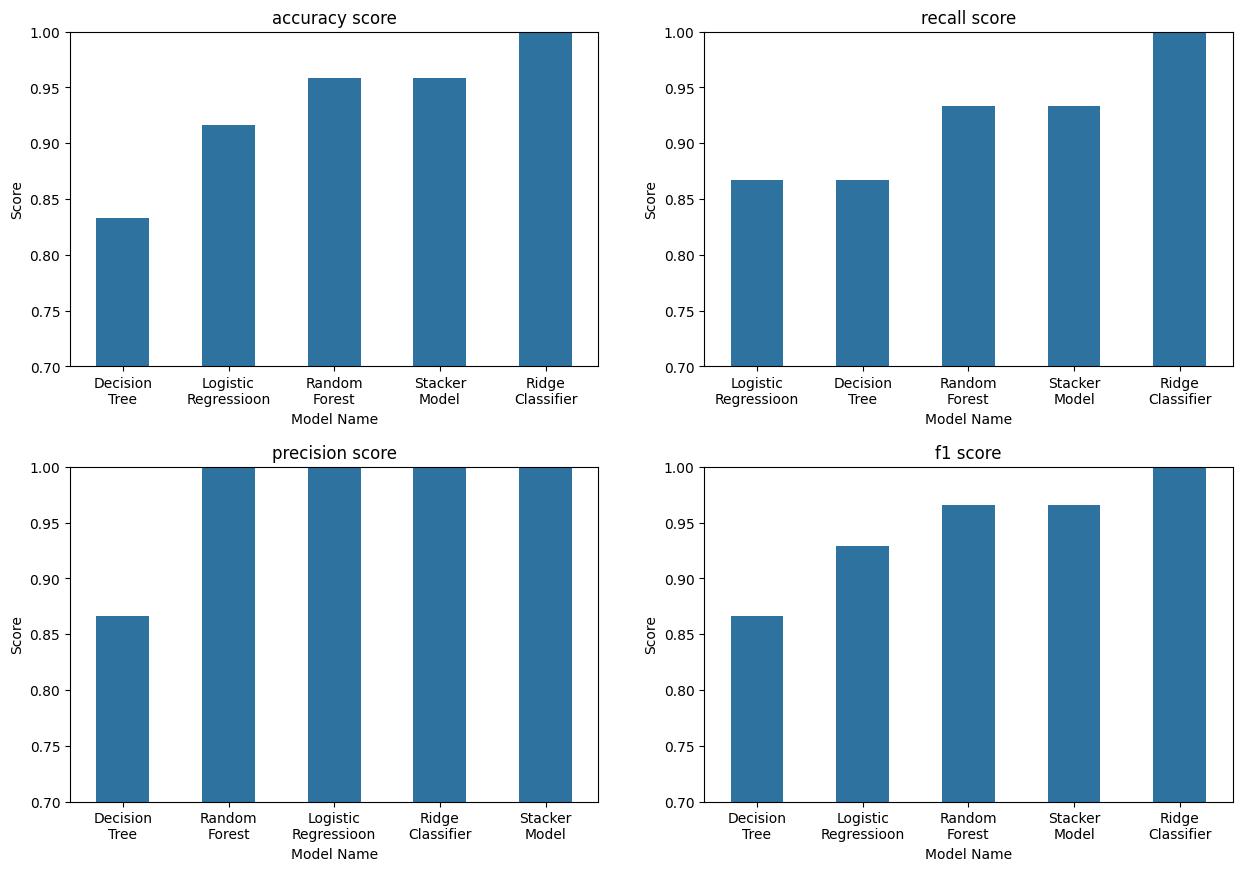

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
((ax1, ax2), (ax3, ax4)) = axes

for ax, score in zip([ax1, ax2, ax3, ax4], results.columns[1:]):
    ax.set_title(f'{score} score')
    ax.set_ylabel('Score')
    results.set_index('model')[score].sort_values().plot(kind='bar', ax=ax, fontsize=10, color='#2E73A0')
    ax.set_xlabel('Model Name')
    ax.set_ylim([0.7, 1])
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

plt.show()